In [1]:
%pylab inline
import geopandas as gpd
import rasterio
from smalllib import crop_raster_rectangle, raster_to_pyvista_mesh

Populating the interactive namespace from numpy and matplotlib


In [2]:
center_coords = np.loadtxt("center_coords.txt")

In [3]:
newbounds = gpd.read_file("crater_bounds.gpkg")
newbounds = newbounds.geometry[0]

base ="rasters/NAC_DTM_CHANGE3_M1144922100_160CM.TIF"
basemap = rasterio.open(base)
cropped2, bmeta = crop_raster_rectangle(basemap, newbounds.bounds[:2], newbounds.bounds[2:])


dem = "rasters/NAC_DTM_CHANGE3.TIF"
dem = rasterio.open(dem)
dem_c, dmeta = crop_raster_rectangle(dem, newbounds.bounds[:2], newbounds.bounds[2:])

/home/luca/data/Documenti-local/notebooks.git/chang_data/smalllib.py:220: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolormesh(Xt, Yt, array,*args, **kwargs)


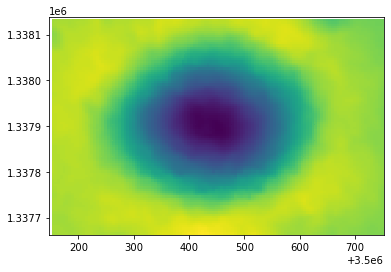

In [4]:
from smalllib import generate_pixel_coordinates, transform_pixel_coorindates, show_raster


show_raster(dem_c[0], dmeta)

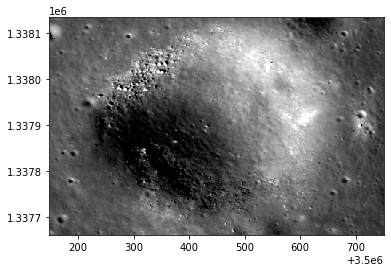

In [5]:
show_raster(cropped2[0], bmeta, cmap="gray")

In [6]:
T = dmeta["transform"]

T = np.array(T).reshape(3, 3)

asmesh = raster_to_pyvista_mesh(dem_c[0], T)

asmesh.points -= center_coords # recenter the mesh
asmesh.points /=1000

# add the mesh to the 3D view
# bp.add_mesh(asmesh)
asmesh.save("dtm2.vtp")


asmesh = asmesh.compute_normals(flip_normals=True)

In [7]:
import vtk, pyvista


In [8]:
mapper = vtk.vtkTextureMapToPlane()
mapper.SetInputData(asmesh)
mapper.Update()

In [9]:
o = mapper.GetOutput()

tx = pyvista.Texture(cropped2[0])
asim = tx.GetImageDataInput(0)


In [10]:
import pyvista
pyvista.PolyData(o).save("dtm3.vtp")

In [11]:
w = vtk.vtkOBJWriter()

w.SetInputData(pyvista.PolyData(o))
w.AddInputDataObject (1,asim)
w.SetFileName("dem.obj")
w.Update()

In [14]:
save_mesh_and_texture_as_obj("mydem.obj", asmesh, cropped2[0])